# Problem Statement 
The problem for this week is to use a generative adversarial network to generate Monet-style images from photographs. 7,000 to 10,000 of the Monet-style images are to be generated. This is an on-going competition on Kaggle. This was completed utilizing teh provided tutorial from Amy Jang as a guide. 

In [1]:
import numpy as np 
import pandas as pd 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from kaggle_datasets import KaggleDatasets
import matplotlib.pyplot as plt
import cv2 as cv
import os



2025-04-23 16:52:13.278759: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745427133.464628      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745427133.522203      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Exploratory Data Analysis

First ensure the applicable hardware resources are configured optimally. 

In [2]:
def setup_strategy():
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        tf.config.experimental_connect_to_cluster(tpu)
        tf.tpu.experimental.initialize_tpu_system(tpu)
        strategy = tf.distribute.TPUStrategy(tpu)
        device = 'TPU'
    except:
        gpus = tf.config.list_physical_devices('GPU')
        if gpus:
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            strategy = tf.distribute.MirroredStrategy() if len(gpus) > 1 else tf.distribute.get_strategy()
            device = f'{len(gpus)} GPU(s)'
        else:
            strategy = tf.distribute.get_strategy()
            device = 'CPU'
    print(f'Using {device} with {strategy.num_replicas_in_sync} replicas')
    return strategy

strategy = setup_strategy()

Using CPU with 1 replicas


2025-04-23 16:52:25.805508: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Get the filenames of the Monet images and the photos that will be used to create the Monet-like images. 

In [3]:
monet_filenames = tf.io.gfile.glob('/kaggle/input/gan-getting-started/monet_tfrec/*.tfrec')
photo_filenames = tf.io.gfile.glob('/kaggle/input/gan-getting-started/photo_tfrec/*.tfrec')

Per Kaggle's overview, the images are already sized to 256x256; the channel should be set to 3 since they are RGB, and the images also need to be scaled from -1 to 1. 

In [4]:
IMAGE_SIZE = [256, 256]

def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

def load_dataset(filenames):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord)
    return dataset



Load the data sets

In [5]:
monet_ds = load_dataset(monet_filenames).batch(1)
photo_ds = load_dataset(photo_filenames).batch(1)

View a preview of a couple of the Monet images and the photos in the provided dataset. 

In [ ]:
# Plot images from Monet dataset
monets = iter(monet_ds)
fig, axes = plt.subplots(nrows = 3, ncols = 3, figsize = (20, 10))
fig.suptitle('Monet Files', fontsize = 16)
ax = axes.flatten()
for i in range(9):
    monet = next(monets)
    ax[i].imshow(monet[0] * 0.5 + 0.5)
    ax[i].axis('off')
plt.show()

# Plot image from photo dataset
photos = iter(photo_ds)
fig, axes = plt.subplots(nrows = 3, ncols = 3, figsize = (20, 10))
fig.suptitle('Photo Files', fontsize = 16)
ax = axes.flatten()
for i in range(9):
    photo = next(photos)
    ax[i].imshow(photo[0] * 0.5 + 0.5)
    ax[i].axis('off')
plt.show()

Next, analyze the RGB distributions to see if there are any discernable patterns for the photos and/or Monet images. This was done with a sample of 250 images from each set. The output indicates there are no noticeable patterns in the distributions. 

In [7]:
def get_sample_imgs(path, num=250):
    imgs = []
    filenames = [f for f in os.listdir(path) if f.endswith('.jpg')]
    for name in filenames:
        img_path = os.path.join(path, name)
        img = cv.imread(img_path)
        imgs.append(img)
    return imgs

monet_s = get_sample_imgs('/kaggle/input/gan-getting-started/monet_jpg')
photo_s = get_sample_imgs('/kaggle/input/gan-getting-started/photo_jpg')

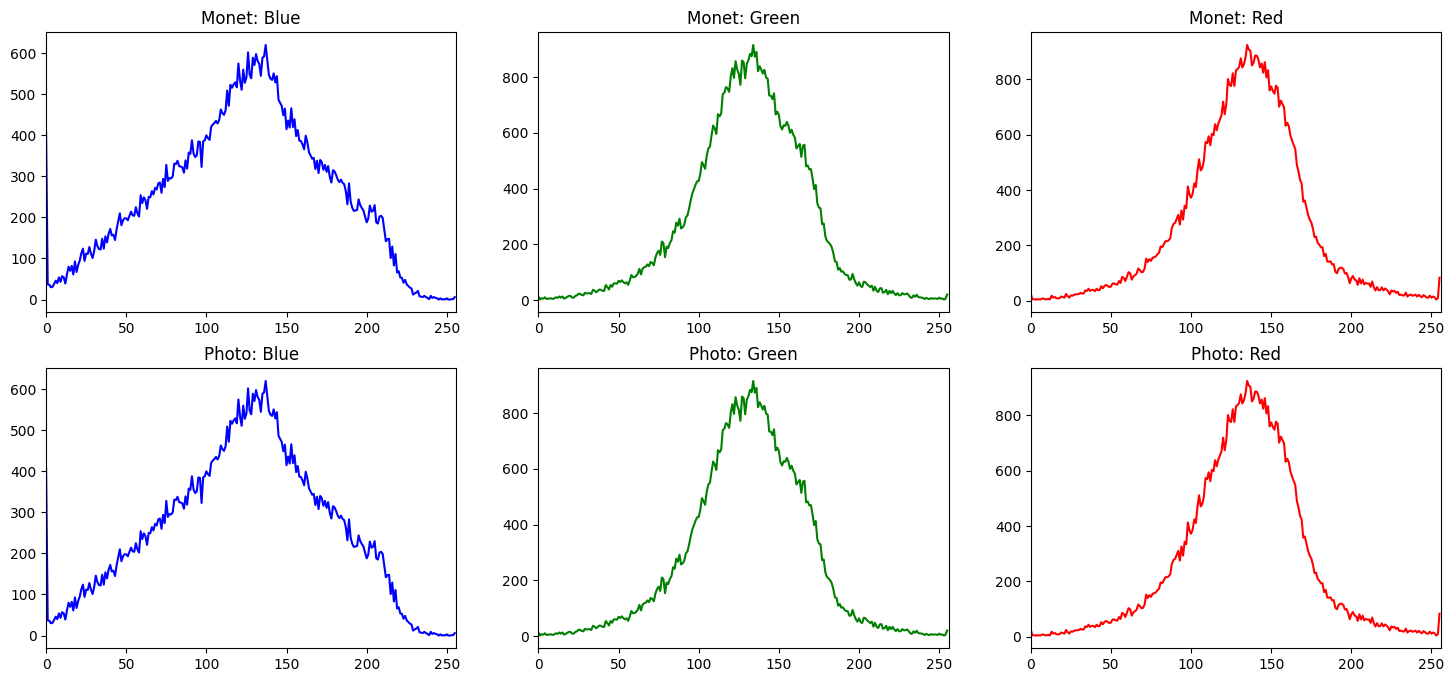

In [8]:
fig,axes = plt.subplots(2, 3, figsize = (18, 8))

colors = ['Blue', 'Green', 'Red']
for i, col in enumerate(colors):
    hist_monet = cv.calcHist(monet_s, [i], None, [256], [0, 256])
    axes[0, i].plot(hist_monet, color = col)
    axes[0, i].set_xlim([0, 256])
    axes[0, i].set_title(f'Monet: {col}')

    hist_photo = cv.calcHist(photo_s, [i], None, [256], [0, 256])
    axes[1, i].plot(hist_monet, color = col)
    axes[1, i].set_xlim([0, 256])
    axes[1, i].set_title(f'Photo: {col}')

plt.show()

# Analysis

First, create the generator architecture. The downsample function reduces the dimensions, and the upsample increases the dimensions of the image. 

In [9]:
OUTPUT_CHANNELS = 3

def downsample(filters, size, apply_instancenorm=True):
    """Downsampling block for the generator"""
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

    if apply_instancenorm:
        result.add(layers.GroupNormalization(groups=-1, gamma_initializer=gamma_init))

    result.add(layers.LeakyReLU())

    return result

def upsample(filters, size, apply_dropout=False):
    """Upsampling block for the generator"""
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))

    result.add(layers.GroupNormalization(groups=-1, gamma_initializer=gamma_init))

    if apply_dropout:
        result.add(layers.Dropout(0.5))

    result.add(layers.ReLU())

    return result

def Generator():
    inputs = layers.Input(shape=[256, 256, 3])

    # Downsampling path
    down_stack = [
        downsample(64, 4, apply_instancenorm=False),  # (bs, 128, 128, 64)
        downsample(128, 4),  # (bs, 64, 64, 128)
        downsample(256, 4),  # (bs, 32, 32, 256)
        downsample(512, 4),  # (bs, 16, 16, 512)
        downsample(512, 4),  # (bs, 8, 8, 512)
        downsample(512, 4),  # (bs, 4, 4, 512)
        downsample(512, 4),  # (bs, 2, 2, 512)
        downsample(512, 4),  # (bs, 1, 1, 512)
    ]

    # Upsampling path
    up_stack = [
        upsample(512, 4, apply_dropout=True),  # (bs, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True),  # (bs, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True),  # (bs, 8, 8, 1024)
        upsample(512, 4),  # (bs, 16, 16, 1024)
        upsample(256, 4),  # (bs, 32, 32, 512)
        upsample(128, 4),  # (bs, 64, 64, 256)
        upsample(64, 4),  # (bs, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                 strides=2,
                                 padding='same',
                                 kernel_initializer=initializer,
                                 activation='tanh')  # (bs, 256, 256, 3)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)

    return keras.Model(inputs=inputs, outputs=x)

Create the discriminator architecture. A PatchGAN discriminator was selected for this problem based on the TensorFlow documentation recommendations. 

In [10]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    inp = layers.Input(shape=[256, 256, 3], name='input_image')

    x = inp

    # Downsampling layers
    down1 = downsample(64, 4, apply_instancenorm=False)(x)  # (bs, 128, 128, 64)
    down2 = downsample(128, 4)(down1)  # (bs, 64, 64, 128)
    down3 = downsample(256, 4)(down2)  # (bs, 32, 32, 256)

    # Additional layers
    zero_pad1 = layers.ZeroPadding2D()(down3)  # (bs, 34, 34, 256)
    conv = layers.Conv2D(512, 4, strides=1,
                        kernel_initializer=initializer,
                        use_bias=False)(zero_pad1)  # (bs, 31, 31, 512)

    norm1 = layers.GroupNormalization(groups=-1, gamma_initializer=gamma_init)(conv)
    leaky_relu = layers.LeakyReLU()(norm1)
    zero_pad2 = layers.ZeroPadding2D()(leaky_relu)  # (bs, 33, 33, 512)

    # Output layer - no activation to use with BCE loss
    last = layers.Conv2D(1, 4, strides=1,
                        kernel_initializer=initializer)(zero_pad2)  # (bs, 30, 30, 1)

    return tf.keras.Model(inputs=inp, outputs=last)

In [11]:
with strategy.scope():
    monet_generator = Generator()  
    photo_generator = Generator()  
    monet_discriminator = Discriminator()
    photo_discriminator = Discriminator()

Create a CycleGan instance.

In [12]:
class CycleGan(keras.Model):
    def __init__(
        self,
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator,
        lambda_cycle=10,
    ):
        super().__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        
    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super().compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        
        print(f"train_step received shapes: {real_monet.shape}, {real_photo.shape}")
    
        # Ensure 4D tensors - reshape if needed
        if len(real_monet.shape) > 4:
            real_monet = tf.reshape(real_monet, [-1, 256, 256, 3])
        if len(real_photo.shape) > 4:
            real_photo = tf.reshape(real_photo, [-1, 256, 256, 3])
        
        with tf.GradientTape(persistent=True) as tape:
            # forward cycle
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)
            
            # backward cycle
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)
            
            # Identity mapping
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)
            
            # Discriminator outputs
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            
            disc_real_photo = self.p_disc(real_photo, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)
            
            # Generator losses
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)
            
            # Cycle consistency losses
            total_cycle_loss = (
                self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) +
                self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)
            )
            
            # Identity losses
            total_monet_gen_loss = (
                monet_gen_loss + 
                total_cycle_loss + 
                self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            )
            
            total_photo_gen_loss = (
                photo_gen_loss + 
                total_cycle_loss + 
                self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)
            )
            
            # Discriminator losses
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)
            
        # Calculate gradients
        monet_generator_gradients = tape.gradient(
            total_monet_gen_loss, self.m_gen.trainable_variables
        )
        photo_generator_gradients = tape.gradient(
            total_photo_gen_loss, self.p_gen.trainable_variables
        )
        
        monet_discriminator_gradients = tape.gradient(
            monet_disc_loss, self.m_disc.trainable_variables
        )
        photo_discriminator_gradients = tape.gradient(
            photo_disc_loss, self.p_disc.trainable_variables
        )
        
        # Apply gradients
        self.m_gen_optimizer.apply_gradients(
            zip(monet_generator_gradients, self.m_gen.trainable_variables)
        )
        self.p_gen_optimizer.apply_gradients(
            zip(photo_generator_gradients, self.p_gen.trainable_variables)
        )
        
        self.m_disc_optimizer.apply_gradients(
            zip(monet_discriminator_gradients, self.m_disc.trainable_variables)
        )
        self.p_disc_optimizer.apply_gradients(
            zip(photo_discriminator_gradients, self.p_disc.trainable_variables)
        )
        
        # Return metrics
        return {
            "monet_gen_loss": tf.reduce_mean(total_monet_gen_loss),
            "photo_gen_loss": tf.reduce_mean(total_photo_gen_loss),
            "monet_disc_loss": tf.reduce_mean(monet_disc_loss),
            "photo_disc_loss": tf.reduce_mean(photo_disc_loss)
        }

Next, define loss functions


In [13]:
with strategy.scope():
    def discriminator_loss(real, generated):
        real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)

        generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)

        total_disc_loss = real_loss + generated_loss

        return total_disc_loss * 0.5

with strategy.scope():
    def generator_loss(generated):
        return tf.keras.losses.BinaryCrossentropy(
            from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(
            tf.ones_like(generated), generated)

with strategy.scope():
    def calc_cycle_loss(real_image, cycled_image, LAMBDA):
        loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

        return LAMBDA * loss1

with strategy.scope():
    def identity_loss(real_image, same_image, LAMBDA):
        loss = tf.reduce_mean(tf.abs(real_image - same_image))
        return LAMBDA * 0.5 * loss

Train the model.

In [14]:
with strategy.scope():
    monet_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

    monet_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [15]:
with strategy.scope():
    cycle_gan_model = CycleGan(
        monet_generator, photo_generator, monet_discriminator, photo_discriminator
    )

    cycle_gan_model.compile(
        m_gen_optimizer = monet_generator_optimizer,
        p_gen_optimizer = photo_generator_optimizer,
        m_disc_optimizer = monet_discriminator_optimizer,
        p_disc_optimizer = photo_discriminator_optimizer,
        gen_loss_fn = generator_loss,
        disc_loss_fn = discriminator_loss,
        cycle_loss_fn = calc_cycle_loss,
        identity_loss_fn = identity_loss
    )

In [16]:
cycle_gan_model.fit(
    tf.data.Dataset.zip((monet_ds, photo_ds)),
    epochs=15
)

Epoch 1/15
train_step received shapes: (None, 256, 256, 3), (None, 256, 256, 3)
train_step received shapes: (None, 256, 256, 3), (None, 256, 256, 3)
300/300 ━━━━━━━━━━━━━━━━━━━━ 1495s 5s/step - monet_disc_loss: 0.6366 - monet_gen_loss: 5.2251 - photo_disc_loss: 0.5894 - photo_gen_loss: 5.4197
Epoch 2/15


/usr/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


300/300 ━━━━━━━━━━━━━━━━━━━━ 1407s 5s/step - monet_disc_loss: 0.6452 - monet_gen_loss: 3.7122 - photo_disc_loss: 0.6365 - photo_gen_loss: 3.7623
Epoch 3/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 1405s 5s/step - monet_disc_loss: 0.6422 - monet_gen_loss: 3.6051 - photo_disc_loss: 0.5992 - photo_gen_loss: 3.7157
Epoch 4/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 1412s 5s/step - monet_disc_loss: 0.6349 - monet_gen_loss: 3.4602 - photo_disc_loss: 0.6019 - photo_gen_loss: 3.5889
Epoch 5/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 1394s 5s/step - monet_disc_loss: 0.6266 - monet_gen_loss: 3.3357 - photo_disc_loss: 0.6015 - photo_gen_loss: 3.4538
Epoch 6/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 1441s 5s/step - monet_disc_loss: 0.6241 - monet_gen_loss: 3.2335 - photo_disc_loss: 0.5957 - photo_gen_loss: 3.3535
Epoch 7/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 1398s 5s/step - monet_disc_loss: 0.6233 - monet_gen_loss: 3.1857 - photo_disc_loss: 0.5927 - photo_gen_loss: 3.3299
Epoch 8/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 1398s 5s/step - monet_disc_loss: 0.

Displaying results grid...


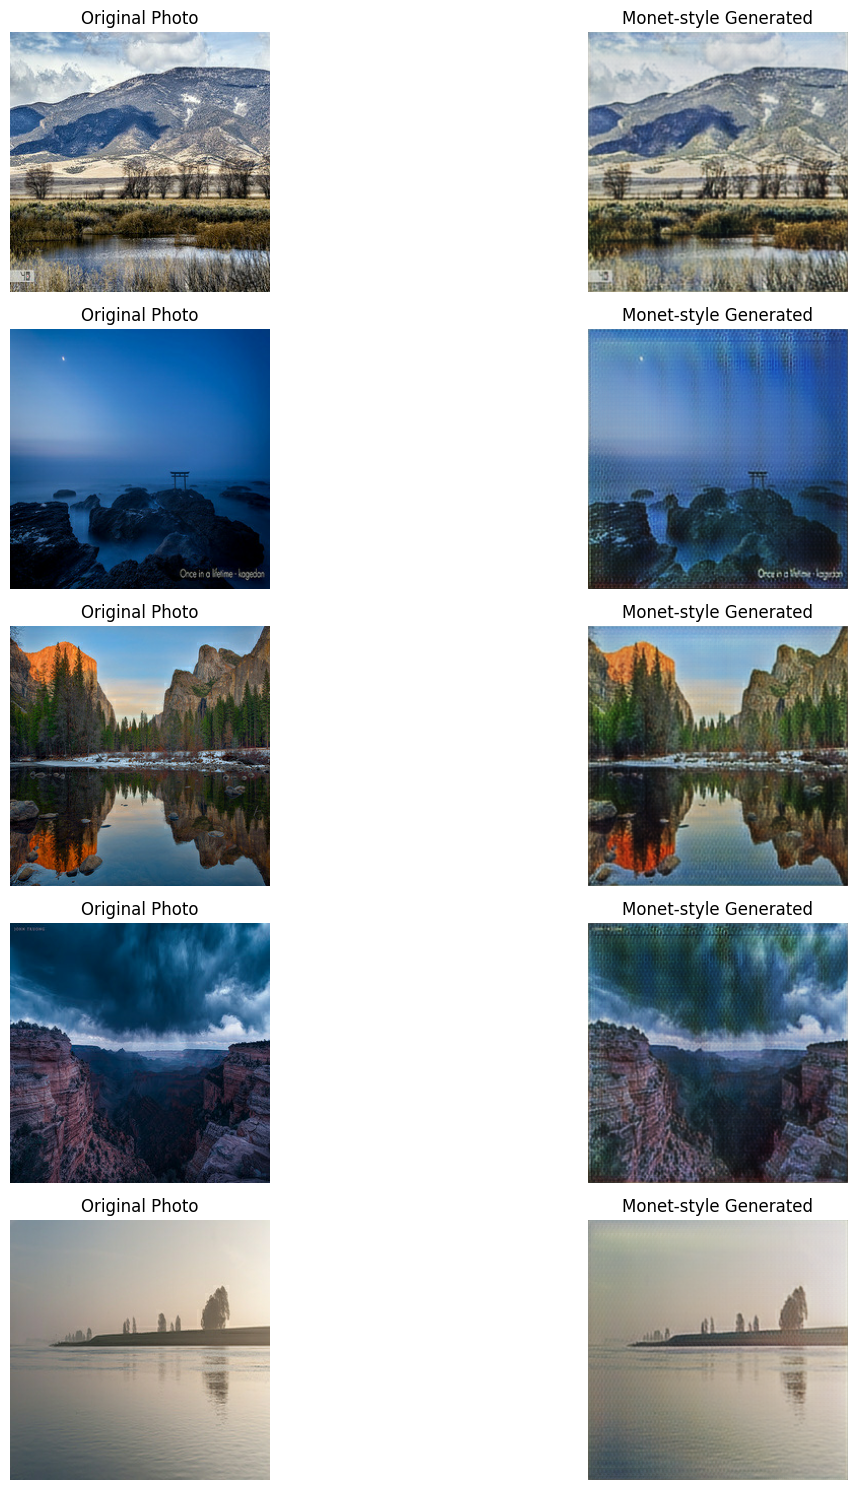

In [17]:
# Display a grid of results
def display_grid(model, ds, num_images=5, figsize=(15, 15)):
    """Display a grid of original and generated images"""
    fig, axes = plt.subplots(num_images, 2, figsize=figsize)
    
    for i, img in enumerate(ds.take(num_images)):
        prediction = model(img, training=False)[0].numpy()
        prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
        
        img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)
        
        axes[i, 0].imshow(img)
        axes[i, 1].imshow(prediction)
        axes[i, 0].set_title("Original Photo")
        axes[i, 1].set_title("Monet-style Generated")
        axes[i, 0].axis("off")
        axes[i, 1].axis("off")
    
    plt.tight_layout()
    plt.show()

# Display results
print("Displaying results grid...")
display_grid(monet_generator, photo_ds, num_images=5)

In [18]:
import PIL
! mkdir ../images

In [19]:
i = 1
for img in photo_ds:
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    im = PIL.Image.fromarray(prediction)
    im.save("../images/" + str(i) + ".jpg")
    i += 1

In [20]:
import shutil
shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/images")

'/kaggle/working/images.zip'

# Results & Discussion

Using the human eye, I'd say the model could have done a better job, but what it did was not terrible. There is a vast amount of tuning that could be done, but I found processing power was quickly used up when trying to do too much to train the model. Ultimately, better hardware would certain achieve better results. 

# Github link:

https://github.com/mattterry13/MS-DS